# PCA
- Principal Component Analysis (PCA) is a procedure that converts a set of observations from m to n dimensions (m > n), after analyzing the correlated features of the variables. It is used to move the data from high to a low dimension for visualization or dimensionality reduction purposes.
### Applying PCA is no different than applying other estimators:
1. create an estimator,
2. fit it on the model to get a transformer,
3. apply the transformer to the data.

## PCA - Visualization
- Dataset of handwritten image has 785 columns. The first column represents a label defining the digit class (0 →9), the other 784 columns represent the pixel values of the 28*28 image.
- Use PCA to reduce the dimensions to only 3

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('PCA_visual').getOrCreate()

In [ ]:
data = spark.read.csv('digits.csv', header=True, inferSchema=True)

In [ ]:
# data.printSchema()

In [ ]:
from pyspark.ml.feature import VectorAssembler

In [ ]:
# output: lable
# input: pixel0 => pixel783
assembler = VectorAssembler(inputCols=data.columns[1:], outputCol='features')
data_2 = assembler.transform(data)

In [ ]:
from pyspark.ml.feature import PCA

In [ ]:
pca = PCA(k=3, inputCol='features', outputCol='features_pca')

In [ ]:
pca_model = pca.fit(data_2)

In [ ]:
pca_model.explainedVariance
# from 784 dementions => 3 dementions: We keep only ~23% value of dataset
# we need more dementions than 3.

DenseVector([0.0975, 0.0716, 0.0615])

In [ ]:
pca_data = pca_model.transform(data_2).select('features_pca')

In [ ]:
pca_data.show(3, truncate=False)

+----------------------------------------------------------+
|features_pca                                              |
+----------------------------------------------------------+
|[103.73881375798472,699.5124334036453,383.7195856009678]  |
|[2466.786278309416,360.75266138892886,-301.36804795392715]|
|[-121.55984060477854,293.9668873776094,267.5928558304658] |
+----------------------------------------------------------+
only showing top 3 rows



In [ ]:
# Change data to df: with 3 columns: label, comp1, comp2
temp = pca_data.select("features_pca").rdd.map(lambda x: x[0].toArray().tolist()).toDF()

In [ ]:
temp.show(5)

+-------------------+-------------------+-------------------+
|                 _1|                 _2|                 _3|
+-------------------+-------------------+-------------------+
| 103.73881375798472|  699.5124334036453|  383.7195856009678|
|  2466.786278309416| 360.75266138892886|-301.36804795392715|
|-121.55984060477854|  293.9668873776094|  267.5928558304658|
|  599.5789910719535|-299.98165533942415| 136.29206078780783|
| 2689.0443094759903|  449.3541744175643| -348.1754772429902|
+-------------------+-------------------+-------------------+
only showing top 5 rows



In [ ]:
import pyspark.sql.functions as f

In [ ]:
data_label= data.select('label')
data_label = data_label.withColumn('row_index', f.monotonically_increasing_id())

temp=temp.withColumn('row_index', f.monotonically_increasing_id())

temp = temp.join(data_label, on=["row_index"]).sort("row_index").drop("row_index")

In [ ]:
temp.show(3)

+-------------------+------------------+-------------------+-----+
|                 _1|                _2|                 _3|label|
+-------------------+------------------+-------------------+-----+
| 103.73881375798472| 699.5124334036453|  383.7195856009678|    1|
|  2466.786278309416|360.75266138892886|-301.36804795392715|    0|
|-121.55984060477854| 293.9668873776094|  267.5928558304658|    1|
+-------------------+------------------+-------------------+-----+
only showing top 3 rows



In [ ]:
temp = temp.select(f.col("_1").alias("comp1"), 
                   f.col("_2").alias("comp2"), 
                   f.col("_3").alias("comp3"), 
                   "label")

In [ ]:
temp.show(3)

+-------------------+------------------+-------------------+-----+
|              comp1|             comp2|              comp3|label|
+-------------------+------------------+-------------------+-----+
| 103.73881375798472| 699.5124334036453|  383.7195856009678|    1|
|  2466.786278309416|360.75266138892886|-301.36804795392715|    0|
|-121.55984060477854| 293.9668873776094|  267.5928558304658|    1|
+-------------------+------------------+-------------------+-----+
only showing top 3 rows



In [ ]:
df = temp.toPandas()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

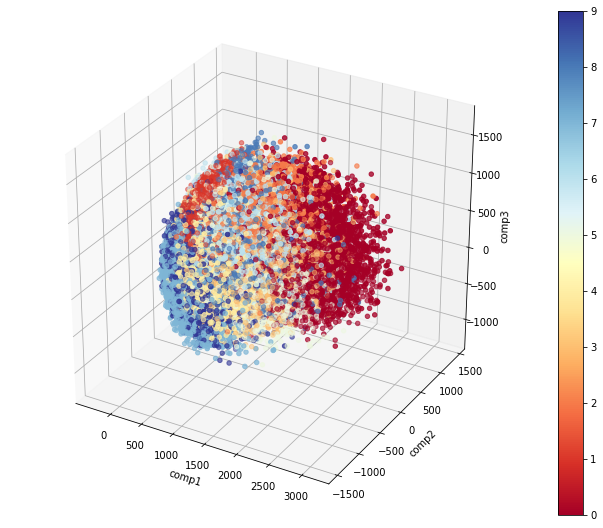

In [ ]:
fig = plt.figure(figsize=(9, 7))
ax = Axes3D(fig) # Method 1
sc = ax.scatter(df['comp1'], df['comp2'], df['comp3'], 
                c=df['label'], marker='o', 
                cmap= plt.cm.get_cmap('RdYlBu'))
ax.set_xlabel('comp1')
ax.set_ylabel('comp2')
ax.set_zlabel('comp3')
plt.colorbar(sc)
plt.show()

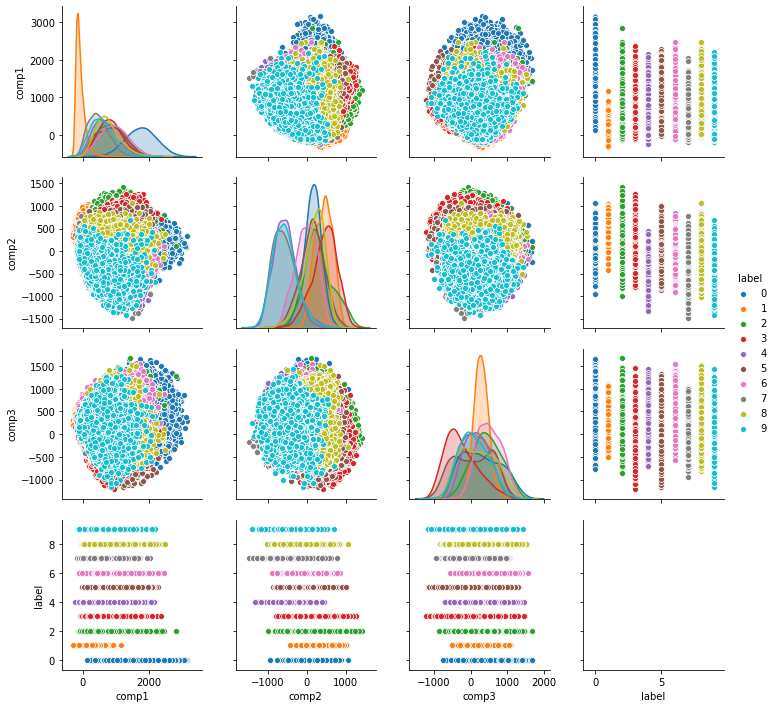

In [ ]:
#Seaborn pair plot
sns.pairplot(df, hue='label')
plt.show()